In [5]:
from dataprep import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import os

In [11]:
path_for_data = 'C:\\Users\\bensa\\Documents\\MRPLocal\\Data'
cgm_data = 'CGM_Processed.csv'
file_cgm = os.path.join(path_for_data, cgm_data)


In [12]:
## Process data and create initial dataFrame
cgm_data = DataCleaning()

In [13]:
## Only run the below if you want to rebuild your data file - due to the size of the source this can take up to an hour to run
#cgm_data.resequenceData(size=3)

## EDA for Project Section

In [14]:
## load dataframe from cleaned data
CGMDf = pd.read_csv(file_cgm)
CGMDf.head()

,Unnamed: 0.1,index,Unnamed: 0,RecID,PtID,ParentCITYDeviceUploadsID,DeviceDtTm,RecordType,Value,Units,SortOrd,ValueMMOL,DDate,hourOfDay,series,series_id
0,0,0,0,1539485,39,651,2000-04-21 04:31:56,CGM,135.0,mg/dL,7880.0,7.5,2000-04-21,4,False,73331
1,1,1,1,1539486,39,651,2000-04-21 04:36:55,CGM,133.0,mg/dL,7881.0,7.4,2000-04-21,4,False,73331
2,2,2,2,1539487,39,651,2000-04-21 04:41:55,CGM,133.0,mg/dL,7882.0,7.4,2000-04-21,4,False,73331
3,3,3,3,1539488,39,651,2000-04-21 04:46:56,CGM,133.0,mg/dL,7883.0,7.4,2000-04-21,4,False,73331
4,4,4,4,1539489,39,651,2000-04-21 04:51:56,CGM,134.0,mg/dL,7884.0,7.4,2000-04-21,4,False,73331


### Cleaning up data:<br>
Removing unused columns<br>
Correcting Datatypes<br>
Removing series with less than 25 observations as those won't provide sufficient detail to create forecast

In [4]:

## drop unnecessary columns to save on space / compute
CGMDf.drop(['Unnamed: 0.1','index','Unnamed: 0','RecordType','Value'], inplace=True, axis=1)

## cleaning up the data -- Resetting data types
CGMDf['DDate']=pd.to_datetime(CGMDf['DDate'])
CGMDf['DeviceDtTm']=pd.to_datetime(CGMDf['DeviceDtTm'])
CGMDf.SortOrd=CGMDf.SortOrd.astype(int)

## cleaning data - removing series where not enough samples to learn / predict
a=pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
a.reset_index(inplace=True)
CGMDf = CGMDf[~CGMDf.series_id.isin(a.series_id[a.RecID<=25].to_list())] ## Remove series where there will be no ability to forecast more than 5 datapoints
CGMDf.shape[0]
## 1 950 448 -- samples remaining


1950448

In [101]:
## looking at remaining structured data
CGMDf.head()

,RecID,PtID,ParentCITYDeviceUploadsID,DeviceDtTm,Units,SortOrd,ValueMMOL,DDate,hourOfDay,series,series_id
0,1539485,39,651,2000-04-21 04:31:56,mg/dL,7880,7.5,2000-04-21,4,False,73331
1,1539486,39,651,2000-04-21 04:36:55,mg/dL,7881,7.4,2000-04-21,4,False,73331
2,1539487,39,651,2000-04-21 04:41:55,mg/dL,7882,7.4,2000-04-21,4,False,73331
3,1539488,39,651,2000-04-21 04:46:56,mg/dL,7883,7.4,2000-04-21,4,False,73331
4,1539489,39,651,2000-04-21 04:51:56,mg/dL,7884,7.4,2000-04-21,4,False,73331


In [23]:
CGMDf.dtypes

RecID                                 int64
PtID                                  int64
ParentCITYDeviceUploadsID             int64
DeviceDtTm                   datetime64[ns]
Units                                object
SortOrd                               int64
ValueMMOL                           float64
DDate                        datetime64[ns]
hourOfDay                             int64
series                                 bool
series_id                             int64
dtype: object

## Basic statistics 
Summary points about the data

In [5]:
## Create a Dictionary of statistics for summary
ptStats = {} ## stat dictionary for people

## number of people in the file
ptStats['number_of_people']=CGMDf.groupby(['PtID'])['RecID'].count().shape[0] 

## avg series per person, max series per person, min series per person
c = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
c.reset_index(inplace=True)
ptStats['number_of_series_per_person_mean'] = c.groupby(['PtID'])['RecID'].count().mean()
ptStats['number_of_series_per_person_max'] = c.groupby(['PtID'])['RecID'].count().max()
ptStats['number_of_series_per_person_min'] = c.groupby(['PtID'])['RecID'].count().min()
ptStatsDf = pd.DataFrame(ptStats.items(),columns=['metric','value'])
ptStatsDf


,metric,value
0,number_of_people,144.000000
1,number_of_series_per_person_mean,123.548611
2,number_of_series_per_person_max,596.000000
3,number_of_series_per_person_min,1.000000


## demonstrate the amount of series available per patient

In [15]:
plt.style.use('ggplot')

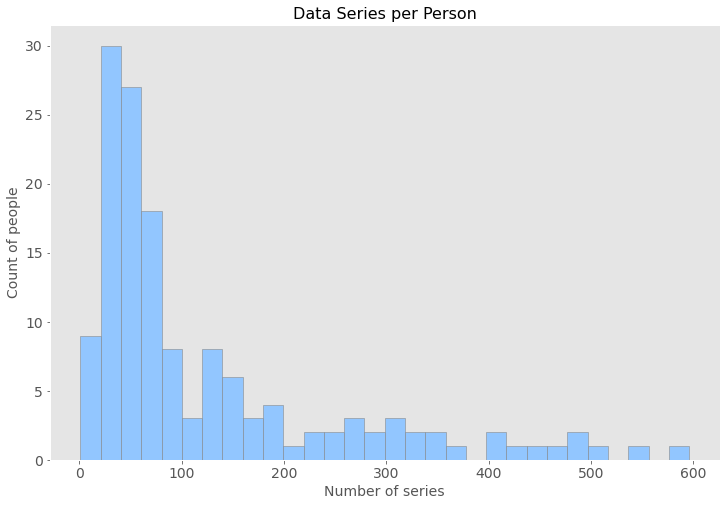

In [16]:
a= pd.DataFrame(c.groupby(['PtID'])['RecID'].count())
a.reset_index(inplace=True)

#plt.clf()
plt.style.use('seaborn-pastel')
fig = pyplot.figure()
a['RecID'].hist(bins=30,figsize=(12,8), grid=False,xlabelsize=14,ylabelsize=14,edgecolor='grey')
pyplot.title('Data Series per Person', fontsize='16',color='black')
pyplot.xlabel('Number of series',fontsize='14')
pyplot.ylabel('Count of people',fontsize='14')

#plt.xticks(np.arange(4, 20, 2))
#plt.yticks(np.arange(0, 20, 2))

#pyplot.savefig('/Users/bsw/Documents/MRPLocal/Figures/MeanBGperPerson.jpg',)
pyplot.show()


In [191]:

## avg series per person, max series per person, min series per person
d = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
d.reset_index(inplace=True)
srStats={} ## series stat dictionary

srStats['series_mean'] = d.RecID.mean()
srStats['series_max'] = d.RecID.max()
srStats['series_min'] = d.RecID.min()
srStats['series_count'] = d.RecID.count()

srDf = pd.DataFrame(srStats.items(),columns=['metric','value'])
srDf
## go back up and fix for dataframe


,metric,value
0,series_mean,109.631162
1,series_max,1258.000000
2,series_min,26.000000
3,series_count,17791.000000


## Plotting mean BG by person in the data set to understand in general how the target variable is distributed by the person

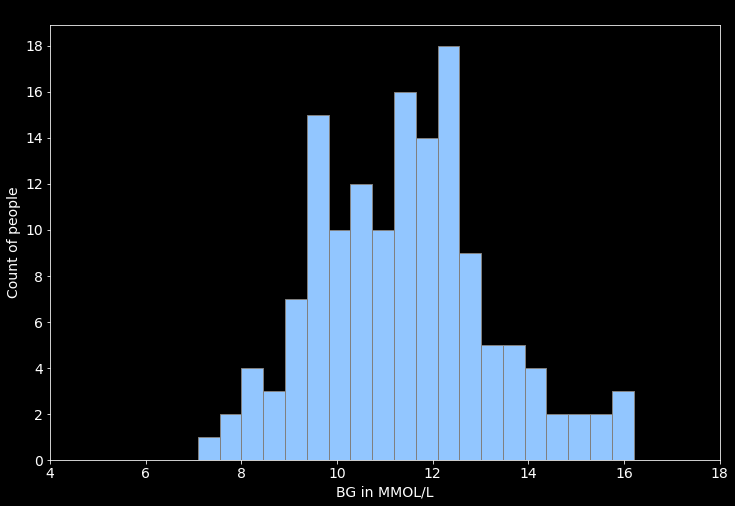

In [14]:
CGMDf.head()
BGbyPerson = CGMDf.groupby('PtID').agg({'ValueMMOL': ['mean', 'min', 'max','std']})
BGbyPerson.reset_index(inplace=True)
#BGbyPerson
#BGbyPerson.ValueMMOL.mean
AA = BGbyPerson.droplevel(0, axis=1)

plt.style.use('seaborn-pastel')
fig = pyplot.figure()
AA['mean'].hist(bins=20, figsize=(12,8), grid=False,xlabelsize=14,ylabelsize=14,edgecolor='grey')
pyplot.title('Mean BG per Person', fontsize='16',color='black')
pyplot.xlabel('BG in MMOL/L',fontsize='14')
pyplot.ylabel('Count of people',fontsize='14')

plt.xticks(np.arange(4, 20, 2))
plt.yticks(np.arange(0, 20, 2))

#pyplot.savefig('/Users/bsw/Documents/MRPLocal/Figures/MeanBGperPerson.jpg',)
pyplot.show()

## Plot a few of the series to explore visually and determine if any treatment may be considered after reviewing

In [22]:
CGMDf.groupby('PtID').count()
PtIDSample = [180,181,5,6]

## find Series_id to sample
SeriesSample=[96712,96740, ## pt 180
91021,91095, ##pt 181
85996,106371] ##pt 5

#CGMDf[CGMDf['PtID']==PtIDSample[2]]


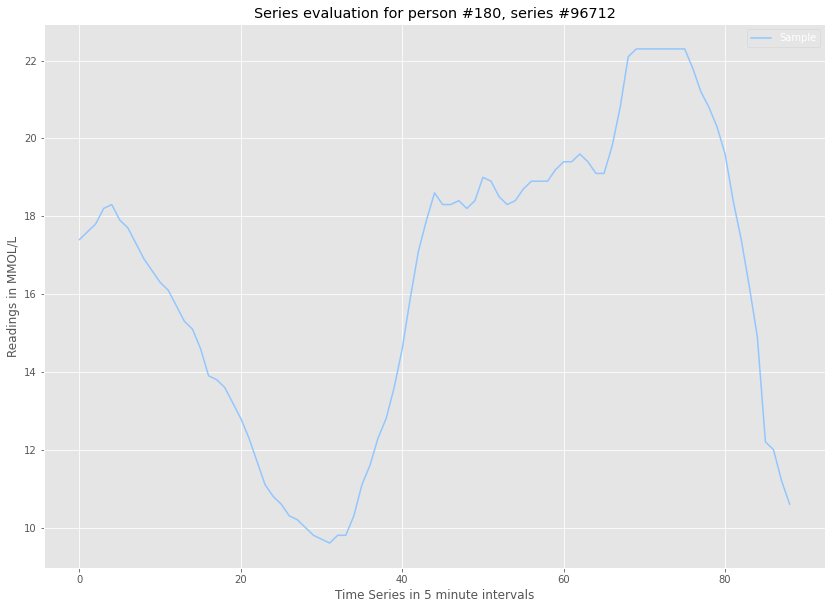

In [189]:
y = CGMDf[CGMDf.series_id==SeriesSample[0]].ValueMMOL.to_list()

plt.figure(figsize=(14,10))
plt.plot(y, label='Sample')
plt.xlabel('Time Series in 5 minute intervals')
plt.ylabel('Readings in MMOL/L')
plt.title('Series evaluation for person #180, series #96712',color='black')
plt.legend()
plt.show()
#plt.clf()

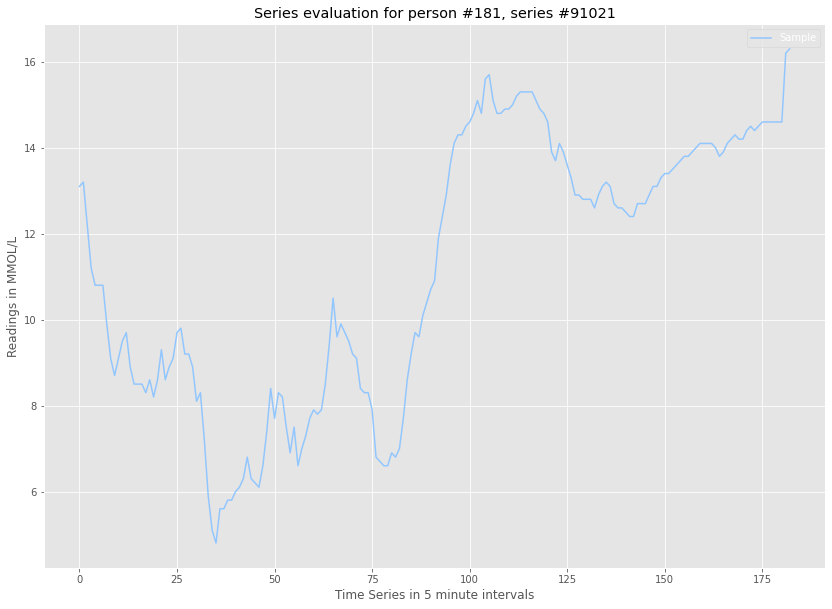

In [190]:
y = CGMDf[CGMDf.series_id==SeriesSample[2]].ValueMMOL.to_list()

plt.figure(figsize=(14,10))
plt.plot(y, label='Sample')
plt.xlabel('Time Series in 5 minute intervals')
plt.ylabel('Readings in MMOL/L')
plt.title('Series evaluation for person #181, series #91021',color='black')
plt.legend()
plt.show()
#plt.clf()

In [109]:
c = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
c.reset_index(inplace=True)
c.groupby(['PtID'])['RecID'].count().mean()

123.54861111111111

In [17]:
grpPTandSeries = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count()) ## number of people in the file
grpPTandSeries[grpPTandSeries['RecID']<=100000].shape[0]

## Remove the sequences less than 10, they will be useless, create stats based on that.

17791

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1008x720 with 0 Axes>

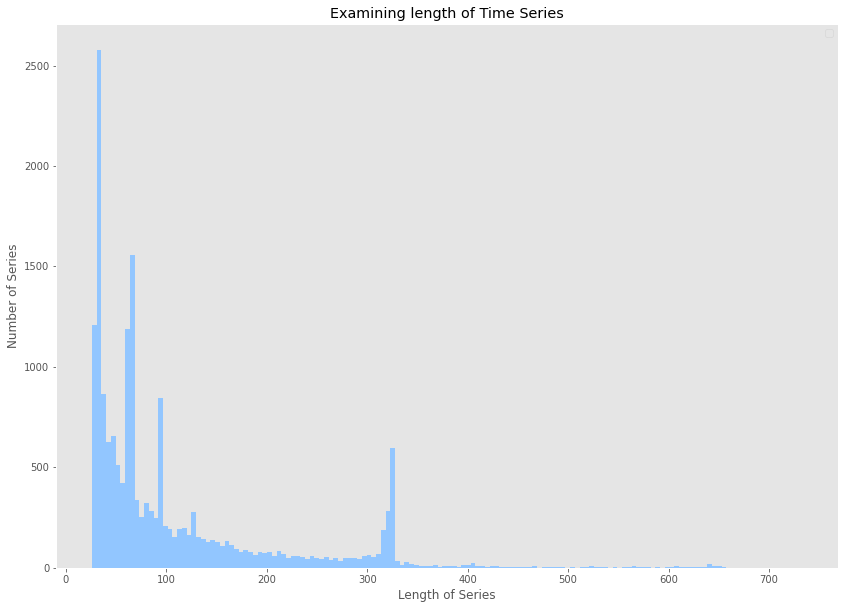

In [20]:
plt.figure(figsize=(14,10))
grpPTandSeries[grpPTandSeries['RecID'].between(0,800)].hist(bins=150,figsize=(14,10),grid=False)
plt.xlabel('Length of Series')
plt.ylabel('Number of Series')
plt.title('Examining length of Time Series',color='black')
plt.legend()
plt.show()

In [32]:
y = CGMDf[CGMDf.series_id==SeriesSample[2]].ValueMMOL.to_list()
ab = []
ab.append(y)
t1 = y[:len(y)//2]
t2 = y[len(y)//2:]
ab.append(t1)
ab.append(t2)
ab

[[13.1,
  13.2,
  12.2,
  11.2,
  10.8,
  10.8,
  10.8,
  9.9,
  9.1,
  8.7,
  9.1,
  9.5,
  9.7,
  8.9,
  8.5,
  8.5,
  8.5,
  8.3,
  8.6,
  8.2,
  8.6,
  9.3,
  8.6,
  8.9,
  9.1,
  9.7,
  9.8,
  9.2,
  9.2,
  8.9,
  8.1,
  8.3,
  7.2,
  5.9,
  5.1,
  4.8,
  5.6,
  5.6,
  5.8,
  5.8,
  6.0,
  6.1,
  6.3,
  6.8,
  6.3,
  6.2,
  6.1,
  6.6,
  7.4,
  8.4,
  7.7,
  8.3,
  8.2,
  7.5,
  6.9,
  7.5,
  6.6,
  7.0,
  7.3,
  7.7,
  7.9,
  7.8,
  7.9,
  8.5,
  9.4,
  10.5,
  9.6,
  9.9,
  9.7,
  9.5,
  9.2,
  9.1,
  8.4,
  8.3,
  8.3,
  7.9,
  6.8,
  6.7,
  6.6,
  6.6,
  6.9,
  6.8,
  7.0,
  7.7,
  8.6,
  9.2,
  9.7,
  9.6,
  10.1,
  10.4,
  10.7,
  10.9,
  11.9,
  12.4,
  12.9,
  13.6,
  14.1,
  14.3,
  14.3,
  14.5,
  14.6,
  14.8,
  15.1,
  14.8,
  15.6,
  15.7,
  15.1,
  14.8,
  14.8,
  14.9,
  14.9,
  15.0,
  15.2,
  15.3,
  15.3,
  15.3,
  15.3,
  15.1,
  14.9,
  14.8,
  14.6,
  13.9,
  13.7,
  14.1,
  13.9,
  13.6,
  13.3,
  12.9,
  12.9,
  12.8,
  12.8,
  12.8,
  12.6,
  12.9,
  13.1,


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


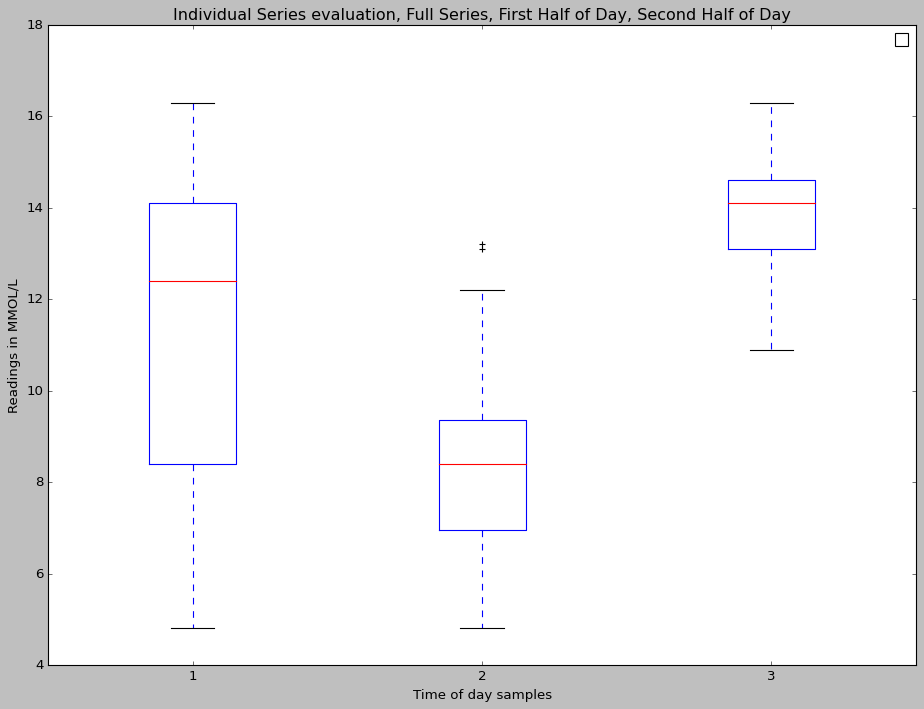

In [34]:
y = CGMDf[CGMDf.series_id==SeriesSample[2]].ValueMMOL.to_list()
plt.style.use('classic')
plt.figure(figsize=(14,10))
plt.boxplot(ab)
plt.xlabel('Time of day samples')
plt.ylabel('Readings in MMOL/L')
plt.title('Individual Series evaluation, Full Series, First Half of Day, Second Half of Day',color='black')
plt.legend()
plt.show()
#plt.clf()

### Ideas

Glucose
Average Glucose by person
min and max per person

Series stats
Series length
Series Min and Max

